In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from ast import literal_eval
from fitter import Fitter
from scipy.stats import expon
from collections import Counter

In [2]:
# get ecDNA intervals from ccle dataset

In [3]:
ccle = pd.read_csv("/Users/michael/Downloads/amplicon_repo_datasets/ccle_aggregated_results.csv")

In [4]:
ccle["Location"] = ccle.apply(lambda x : x["Location"].replace("\"", ""), axis = 1)

In [5]:
ccle_ecdna = ccle[ccle["Classification"] == "ecDNA"]

In [7]:
locations = ccle_ecdna['Location'].to_list()

In [8]:
locations

["['chr6:20350615-22839372']",
 "['chr3:9099507-9519221', 'chr3:9521655-10184493', 'chr3:10187258-14005720']",
 "['chr8:124484622-125582885', 'chr8:125588889-125953950']",
 "['chr8:52712046-56014576', 'chr8:65533018-65573949', 'chr8:71974787-71975210']",
 "['chr8:33167666-33301262', 'chr8:33302858-34254640', 'chr20:34283685-34285398', 'chr20:34299250-34611096']",
 "['chr3:61013233-61105860']",
 "['chr3:195779887-195783346', 'chr3:195783876-195788432', 'chr3:196035694-196047057', 'chr3:196048094-196050519', 'chr3:196051160-196090764', 'chr22:22863501-22941860']",
 "['chr4:161967909-162770269']",
 "['chr20:537320-1408502', 'chr20:1410170-1580396', 'chr20:1613533-1804925']",
 "['chr3:37937674-38298744']",
 "['chr8:71754758-71754831', 'chr8:71755523-72875541', 'chr8:72881587-74450636', 'chr8:74454727-74804209', 'chr8:75084883-75089985', 'chr8:75090041-80890260', 'chr8:80933178-80939945', 'chr8:86806127-87315900', 'chr8:87545736-87559512', 'chr8:87631519-88868891', 'chr8:89749344-90215126',

In [9]:
# MERGE ALGORITHM TOY EXAMPLE

MERGE_DIST = 1
MIN_LEN = 1
    
processed = [(1,8,10), (5,2,4), (1,13,15), (1,16,20), (1,2,4)]
interval_lengths_in_feature = []

running_total = processed[0][2] - processed[0][1]
            
for i in range(len(processed)):
    # add last interval to first interval in interval_lengths_in_feature if merge criteria met
    if i == len(processed)-1:
        interval_lengths_in_feature.append(running_total)

    # if the next interval is sufficiently close to this one
    elif processed[i][0] == processed[i+1][0] and processed[i+1][1]-processed[i][2]<=MERGE_DIST:
        print(i)
        # add the next to merged length
        length = processed[i+1][2]-processed[i+1][1]
        running_total += length
        if length < 0:
            print("OH NO")
    else:
        interval_lengths_in_feature.append(running_total)
        length = processed[i+1][2]-processed[i+1][1]
        running_total = length
        if length < 0:
            print("OH NO")
        
interval_lengths_in_feature

2
3


[2, 2, 8]

In [19]:
MERGE_DIST = 50000
MIN_LEN = 10000

# merge intervals < MERGE_DIST apart,
# then drop intervals < MIN_LEN long
def merge_and_drop(input_list):
    interval_lengths = []
    
    for feature in input_list:
        # convert to list
        intervals = literal_eval(feature)
        nonempty = len(intervals) > 0 and intervals != ['']
        # compute length of each interval
        if nonempty:
            processed = []
            interval_lengths_in_feature = []
            
            for interval in intervals:
                # extract interval info
                pattern = r"chr(\d+|X):(\d+)-(\d+)"
                match = re.search(pattern, interval)
                if match:
                    chr_num, start, end = match.groups()
                else:
                    print(f"No match found for {interval}")
                processed.append((chr_num, int(start), int(end)))
                
            running_total = processed[0][2] - processed[0][1]
            
            for i in range(len(processed)):
                # add last interval to first interval in interval_lengths_in_feature if merge criteria met
                if i == len(processed)-1:
                    interval_lengths_in_feature.append(running_total)

                # if the next interval is sufficiently close to this one
                elif processed[i][0] == processed[i+1][0] and processed[i+1][1]-processed[i][2]<=MERGE_DIST:
                    # add the next to merged length
                    length = processed[i+1][2]-processed[i+1][1]
                    running_total += length
                    if length < 0:
                        print("OH NO")
                else:
                    interval_lengths_in_feature.append(running_total)
                    length = processed[i+1][2]-processed[i+1][1]
                    running_total = length
                    if length < 0:
                        print("OH NO")
                    
            interval_lengths_to_add = [i for i in interval_lengths_in_feature if i > MIN_LEN]
            interval_lengths = interval_lengths + interval_lengths_to_add
        
    return interval_lengths

In [20]:
lengths_merged = merge_and_drop(locations)

In [21]:
min(lengths_merged), max(lengths_merged)

(50696, 9392208)

In [22]:
lengths_merged_df = pd.DataFrame(lengths_merged, columns=['Numbers'])

In [23]:
lengths_merged_df.describe()

,Numbers
count,6.080000e+02
mean,1.007174e+06
std,1.391847e+06
min,5.069600e+04
25%,1.645602e+05
50%,4.890195e+05
75%,1.255804e+06
max,9.392208e+06


2025-02-01 16:59:41.980 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2025-02-01 16:59:41.999 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted anglit distribution with error=0.0)
2025-02-01 16:59:42.013 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted argus distribution with error=0.0)
2025-02-01 16:59:42.014 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted alpha distribution with error=0.0)
2025-02-01 16:59:42.032 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted arcsine distribution with error=0.0)
2025-02-01 16:59:42.060 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted betaprime distribution with error=0.0)
2025-02-01 16:59:42.071 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.0)
2025-02-01 16:59:42.096 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cosine distribution w

2025-02-01 16:59:42.920 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ncf distribution with error=0.0)
2025-02-01 16:59:42.927 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted pearson3 distribution with error=0.0)
2025-02-01 16:59:42.936 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.0)
2025-02-01 16:59:43.029 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powernorm distribution with error=nan)
2025-02-01 16:59:43.037 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.0)
2025-02-01 16:59:43.090 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rdist distribution with error=0.0)
2025-02-01 16:59:43.104 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted genexpon distribution with error=0.0)
2025-02-01 16:59:43.139 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted reciprocal distribution with 

               sumsquare_error          aic          bic  kl_div  \
geninvgauss       1.705228e-13  3578.150135  3596.214908     inf   
johnsonsb         1.739844e-13  3527.690353  3545.755125     inf   
genhyperbolic     1.770963e-13  3580.957986  3603.538951     inf   
fatiguelife       2.036823e-13  3567.513530  3581.062109     inf   
johnsonsu         2.484321e-13  3552.809962  3570.874734     inf   

               ks_statistic  ks_pvalue  
geninvgauss        0.029065   0.606992  
johnsonsb          0.030427   0.548327  
genhyperbolic      0.039277   0.241571  
fatiguelife        0.037479   0.291112  
johnsonsu          0.047795   0.088228  


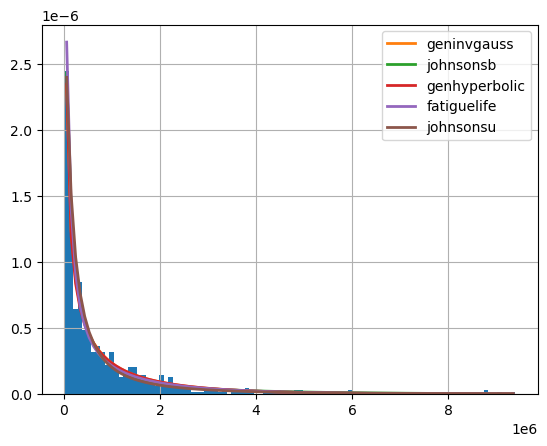

In [15]:
f = Fitter(lengths_merged_df)
f.fit()
print(f.summary())

2025-02-01 17:03:05.526 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0)


       sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon     2.217577e-12  3734.86011  3743.68046     inf      0.155453   

          ks_pvalue  
expon  2.685699e-13  


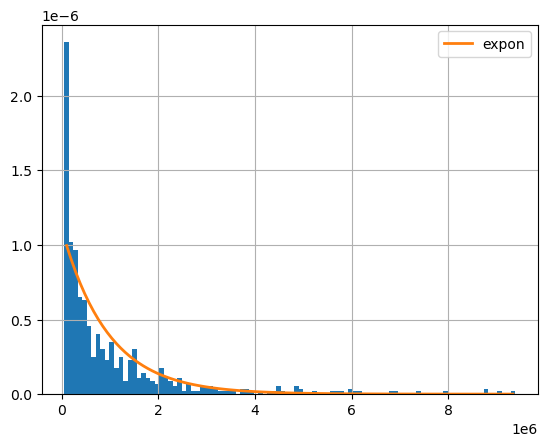

In [24]:
f = Fitter(lengths_merged_df, distributions=['expon'])
f.fit()
print(f.summary())

       sumsquare_error         aic          bic  kl_div  ks_statistic  \
gamma     7.598360e-13  3554.80198  3568.032505     inf       0.06808   

       ks_pvalue  
gamma   0.006792  


2025-02-01 17:03:12.912 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.0)


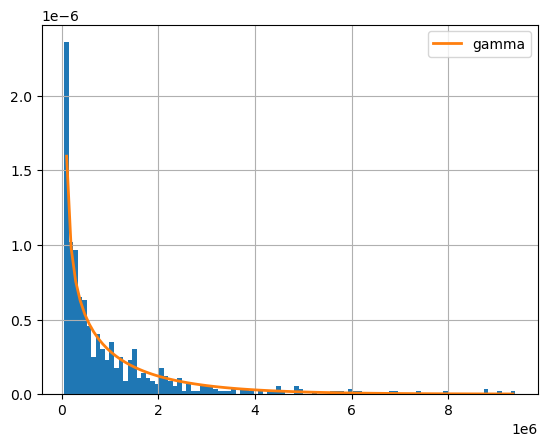

In [25]:
f = Fitter(lengths_merged_df, distributions=['gamma'])
f.fit()
print(f.summary())

In [ ]:
# function to extract lengths from input list
def process_intervals(input_list):
    interval_lengths = []
    feature_lengths = []
    intervals_are_multichr = []
    intervals_under_1000 = []
    chr_nums_list = []
    i = 0
    for feature in input_list:
        # convert to list
        intervals = literal_eval(feature)
        nonempty = len(intervals) > 0 and intervals != ['']
        # compute length of each interval
        if nonempty:
            toSum = []
            chr_nums = []
            for interval in intervals:
                # extract interval info
                pattern = r"chr(\d+|X):(\d+)-(\d+)"
                match = re.search(pattern, interval)
                if match:
                    chr_num, start, end = match.groups()
                else:
                    print(f"No match found for {interval}")
                chr_nums.append(chr_num)
                dist = int(end) - int(start)
                toSum.append(dist)
                # add interval to individual list
                interval_lengths.append(dist)
                chr_nums_list.append(chr_num)
                if dist < 1000:
                    intervals_under_1000.append(chr_num)
            # add summed intervals to feature list
            feature_lengths.append(sum(toSum))
            # check if multichromosomal
            multi_bool = 0
            for num in chr_nums:
                if not num == chr_nums[0]:
                    multi_bool = 1
                    break
            intervals_are_multichr.append(multi_bool)
        if i == 86:
            print(len(toSum))
        i+=1
            
    return interval_lengths, feature_lengths, intervals_are_multichr, intervals_under_1000,chr_nums_list 

In [ ]:
interval_lengths, feature_lengths, intervals_are_multichr,intervals_under_1000,chr_nums_list = process_intervals(locations)

In [ ]:
# small fraction
len(intervals_under_1000), len(interval_lengths), len(intervals_under_1000) / len(interval_lengths)

In [ ]:
len(chr_nums_list)

In [ ]:
for key in Counter(intervals_under_1000):
    print(key,':', (Counter(intervals_under_1000)[key]/len(intervals_under_1000))/(Counter(chr_nums_list)[key]/len(chr_nums_list)))
    

In [ ]:
Counter(chr_nums_list)

In [ ]:
# multichromosomal fraction
sum(intervals_are_multichr), len(feature_lengths), sum(intervals_are_multichr) / len(feature_lengths)

In [ ]:
len(interval_lengths), len(feature_lengths), len(locations)

In [ ]:
# convert to df

In [ ]:
intervals_df = pd.DataFrame(interval_lengths, columns=['Numbers'])

In [ ]:
intervals_single = [i for i,m in zip(interval_lengths, intervals_are_multichr) if not m]

intervals_single_df = pd.DataFrame(intervals_single)

intervals_single_df.describe()

In [ ]:
intervals_df.describe()

In [ ]:
Q1 = intervals_df['Numbers'].quantile(0.25)  # 25th percentile
Q3 = intervals_df['Numbers'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

In [ ]:
lower_threshold, upper_threshold

In [ ]:
intervals_outliers = intervals_df[intervals_df['Numbers'] > upper_threshold]
intervals_outliers.describe()

In [ ]:
intervals_no_outliers = intervals_df[intervals_df['Numbers'] < upper_threshold]

In [ ]:
intervals_no_outliers.describe()

In [ ]:
# using fitter to test different distributions

In [ ]:
f = Fitter(intervals_no_outliers)
f.fit()
print(f.summary())

In [ ]:
# for slides
f = Fitter(intervals_no_outliers, distributions=['fatiguelife','mielke','burr12','johnsonsu','nct','gamma','expon'])
f.fit()
print(f.df_errors)

In [ ]:
f.get_best()

In [ ]:
f = Fitter(intervals_no_outliers, distributions=['gamma'])
f.fit()
print(f.summary())

In [ ]:
f.get_best()

In [ ]:
f = Fitter(intervals_no_outliers, distributions=['expon'])
f.fit()
print(f.summary())

In [ ]:
f.get_best()

In [ ]:
# using scipy to fit the exponential dist

In [ ]:
loc, scale = expon.fit(intervals_no_outliers)

lambda_param = 1/scale

print(f"Fitted lambda: {lambda_param}, loc: {loc}, scale: {scale}")

test_value = 

cdf = expon.cdf(test_value, loc=loc, scale=scale)

1-cdf

In [ ]:
# histogram plots for experimental interval dists

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(intervals_single, bins=50, alpha=0.7)
plt.title("Interval Lengths for Single Chromosome ecDNAs (310)")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(interval_lengths, bins=50, alpha=0.7)
plt.title("Interval Lengths for all CCLE ecDNAs (361)")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
cutoff = 25000
intervals_cutoff = [i for i in interval_lengths if i < cutoff]

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(intervals_cutoff, bins=50, alpha=0.7)
plt.title("Interval Lengths < 100000")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(feature_lengths, bins=50, alpha=0.7)
plt.title("Interval Lengths Summed Per Feature")
plt.xlabel("Length (nt)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# function to save list to text file
def save_list_to_txt(numbers, filename):
    with open(filename, 'w') as f:
        for number in numbers:
            f.write(f"{number}\n")

In [ ]:
save_list_to_txt(lengths1, "ccle_interval_lengths.txt")
save_list_to_txt(lengths2, "ccle_interval_lengths_summed_by_feature.txt")